# 事先准备

## PyTorch的安装

In [ ]:
#!pip install torch torchvision

## 导入所需的软件包

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

##  定义transform



In [2]:
transform = transforms.Compose( [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## 准备训练数据和测试数据

In [3]:
# 学习数据
train_data_with_teacher_labels = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
train_data_loader = torch.utils.data.DataLoader(train_data_with_teacher_labels, batch_size=4,shuffle=True, num_workers=2)
# 测试数据
test_data_with_teacher_labels = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_data_loader = torch.utils.data.DataLoader(test_data_with_teacher_labels, batch_size=4,shuffle=False, num_workers=2)


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 配置分类内容

In [4]:
class_names = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 操作办法

In [5]:
import matplotlib.pyplot as plt
import numpy as np

## 显示图像的函数

In [6]:
def show_image(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

## 查看 CIFAR-10 的内容

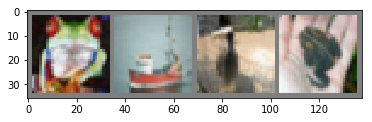

 frog  ship  bird  frog


In [7]:
# 从训练数据中提取一些数据
data_iterator = iter(train_data_loader)
images, labels = data_iterator.next()

# 显示图像
show_image(torchvision.utils.make_grid(images))
# 显示标签
print(' '.join('%5s' % class_names[labels[j]] for j in range(4)))

## 训练用神经网络的定义



In [8]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.layer1 = nn.Linear(16 * 5 * 5, 120)
    self.layer2 = nn.Linear(120, 84)
    self.layer3 = nn.Linear(84, 10)

  def forward(self, input_data):
    input_data = self.pool(F.relu(self.conv1(input_data)))
    input_data = self.pool(F.relu(self.conv2(input_data)))
    input_data = input_data.view(-1, 16 * 5 * 5)
    input_data = F.relu(self.layer1(input_data))
    input_data = F.relu(self.layer2(input_data))
    input_data = self.layer3(input_data)
    return input_data

model = CNN()

## 配置optimizer

In [9]:
import torch.optim as optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.SGD(model.parameters(), lr=0.001, momentum=0.9)

## 学习

In [10]:
# 最大学习次数
MAX_EPOCH=3

#
for epoch in range(MAX_EPOCH):

  total_loss = 0.0
  for i, data in enumerate(train_data_loader, 0):
    # 从数据中检索训练数据和教师标签数据
    train_data, teacher_labels = data

    # 删除计算出的梯度信息
    optimizer.zero_grad()

    # 计算模型中的预测
    outputs = model(train_data)
    
    # 用loss和w进行微分
    loss = criterion(outputs, teacher_labels)
    loss.backward()
    
    # 更新梯度
    optimizer.step()

    # 累计误差
    total_loss += loss.item()
    
    # 以2000个小型批处理为单位显示进度
    if i % 2000 == 1999:
      print('学习进度：[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, total_loss / 2000))
      total_loss = 0.0

print('学习完成')

学习进度：[1,  2000] loss: 2.216
学习进度：[1,  4000] loss: 1.927
学习进度：[1,  6000] loss: 1.709
学习进度：[1,  8000] loss: 1.635
学习进度：[1, 10000] loss: 1.538
学习进度：[1, 12000] loss: 1.455
学习进度：[2,  2000] loss: 1.419
学习进度：[2,  4000] loss: 1.369
学习进度：[2,  6000] loss: 1.352
学习进度：[2,  8000] loss: 1.342
学习进度：[2, 10000] loss: 1.297
学习进度：[2, 12000] loss: 1.290
学习进度：[3,  2000] loss: 1.220
学习进度：[3,  4000] loss: 1.200
学习进度：[3,  6000] loss: 1.222
学习进度：[3,  8000] loss: 1.223
学习进度：[3, 10000] loss: 1.169
学习进度：[3, 12000] loss: 1.185
学习完成


## 用个别数据进行测试

In [ ]:
data_iterator = iter(test_data_loader)
images, labels = data_iterator.next()

# 显示图像
show_image(torchvision.utils.make_grid(images))
print('正确教师标签: ', ' '.join('%5s' % class_names[labels[j]] for j in range(4)))

## 测试

In [ ]:
outputs = model(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('预测: ', ' '.join('%5s' % class_names[predicted[j]] for j in range(4)))

## 验证

In [ ]:
count_when_correct = 0
total = 0
with torch.no_grad():
  for data in test_data_loader:
    test_data, teacher_labels = data
    results = model(test_data)
    _, predicted = torch.max(results.data, 1)
    total += teacher_labels.size(0)
    count_when_correct += (predicted == teacher_labels).sum().item()

print('10000 验证图像的正确率: %d %%' % (100 * count_when_correct / total))

## 每个类的测试结果

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
#
with torch.no_grad():
  for data in test_data_loader:
    #  
    test_data, teacher_labels = data
    #
    results = model(test_data)
    #
    _, predicted = torch.max(results, 1)
    #
    c = (predicted == teacher_labels).squeeze()
    #
    for i in range(4):
      label = teacher_labels[i]
      #
      class_correct[label] += c[i].item()
      class_total[label] += 1


for i in range(10):
  print(' %5s 类的正确率是: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))